# Steganalysis ROC/AUC Curves

This document contains some tools to generate ROC/AUC curves, and then generates several curves for our suite of Steganalysis tools, on a sample encoded image bank.

## Set-up

### Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Modules

In [2]:
!pip install scikit-plot 

### SteganoGAN

In [3]:
!git clone https://github.com/jnickg/steganet

fatal: destination path 'steganet' already exists and is not an empty directory.


### Alethia

In [4]:
!git clone https://github.com/daniellerch/aletheia.git
!sudo apt-get -qq install octave octave-image octave-signal
!sudo apt-get -qq update
!sudo apt-get -qq install liboctave-dev imagemagick
!pip install -r aletheia/requirements.txt
!pip install efficientnet

fatal: destination path 'aletheia' already exists and is not an empty directory.


### StegExpose

In [5]:
# Install the Java JDK.
!apt-get install default-jdk > /dev/null

# Check the Java version to see if everything is working well.
!javac -version

!git clone https://github.com/b3dk7/StegExpose

javac 11.0.11
fatal: destination path 'StegExpose' already exists and is not an empty directory.


## Statistical Steganalysis

We use `StegExpose` to evaluate our encoded images using a suite of statistical attacks.

Save the results to `stegexpose_analysis`, so we can later extract results from the many tools it encompasses.

Specifically, we'll look at:
* Chi Square Attack (Westfeld, 1999)
* RS Analysis (Fridrich, 2001)
* Primary Sets (Dumitrescu, 2002)

### Sample

In [6]:
!java -jar ./StegExpose/StegExpose.jar /content/steganet/assets/test_images/ default default steg_expose.csv
!awk '!/^$/' steg_expose.csv > steg_expose_clean.csv
stegexpose_results_file = 'steg_expose_clean.csv'

#### Overall Results

In [7]:
from prettytable import from_csv

with open(stegexpose_results_file) as fp:
  stegexpose_analysis = from_csv(fp)
  print(stegexpose_analysis)

+------------------+------------------------+-------------------------------------------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+
|    File name     | Above stego threshold? | Secret message size in bytes (ignore for clean files) |      Primary Sets     |      Chi Square      |     Sample Pairs    |     RS analysis      |     Fusion (mean)     |
+------------------+------------------------+-------------------------------------------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+
| Dense_output.png |         false          |                         404960                        |          NaN          | 0.002974292221644861 | 0.07730278219798781 | 0.07567560042732396  |  0.051984224948985545 |
| Basic_output.png |         false          |                         190226                        |  0.02950287639129132  | 0.

#### Loading to Memory

Rather than just dumping the data to a pretty table, let's now load it into a 2-D "tensor" of results, where the first axis is the input file name, and the second axis is the attack vector. Elements are $[0.0,1.0]$ probabilities based on that attack.

In [8]:
import csv
import numpy as np

# Takes a function that returns either 1 or 0 based on the filename
def stegexpose_file_to_data(filename, file_ck_fn=None):
  with open(filename) as fp:
    results = []
    files = []
    actuals = []
    reader = csv.reader(fp)
    next(reader) # skip header
    for row in reader:
      if len(row) > 0:
        files.append(row[0])
        results.append(row[3:])
        label = 1 # assume it was encoded unless it's an input image
        if file_ck_fn is not None:
          label = file_ck_fn(row[0])
        actuals.append(label)
  files = np.array(files)
  results = np.array(results)
  actuals = np.array(actuals)
  return files, actuals, results

In [9]:
def sample_file_ck_fn(name):
  if 'input' in name:
    return 0
  else:
    return 1

stegexpose_files, stegexpose_actuals, stegexpose_results = stegexpose_file_to_data(stegexpose_results_file, file_ck_fn=sample_file_ck_fn)

In [10]:
print(stegexpose_files)

['Dense_output.png' 'Basic_output.png' 'input (1).png']


In [11]:
print(stegexpose_results)

[['NaN' '0.002974292221644861' '0.07730278219798781'
  '0.07567560042732396' '0.051984224948985545']
 ['0.02950287639129132' '0.009233439993378239' '0.03330575897854599'
  '0.029716130698238086' '0.02543955151536341']
 ['0.0027757271722806953' '8.820295629479369E-4' '0.00931381861772712'
  '0.009866536838759855' '0.0057095280479289015']]


In [12]:
print(stegexpose_actuals)

[1 1 0]


#### Extracting a single set of results

These values represent probabilities based on the given attack, that 

In [13]:
primary_sets_idx = 0
chi_square_idx = 1
sample_pairs_idx = 2
rs_analysis_idx = 3
fusion_idx = 4

In [14]:
def extract_column(csv_data, idx):
  results = np.array([float(r) if 'null' not in r else float(0) for r in csv_data[:,idx] ])
  results = np.nan_to_num(results)
  # print(f'Extracted column {idx}: {results}')
  return results

In [15]:
chi_square_results = extract_column(stegexpose_results, chi_square_idx)
print(chi_square_results)

[0.00297429 0.00923344 0.00088203]


#### ROC Curves

Based on the results of our statistical steganalysis, which contains probability values, we now increase our threshold and plot ROC data.

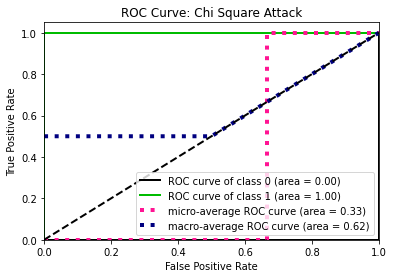

In [16]:
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

# Takes a 1D array of actual labels, the predictions of some model, and the name to dispaly on the chart
def print_roc_for(actual_labels, predictions, name):
  probs = np.reshape(np.concatenate((1.0-predictions,predictions)), (-1, 2))
  skplt.metrics.plot_roc(actual_labels, probs)
  plt.title(f'ROC Curve: {name}')
  plt.show()

print_roc_for(stegexpose_actuals, chi_square_results, "Chi Square Attack")

Now that we are able to generate a single ROC curve, let's put it together and generate curves for all of our attack vectors, based on the steganalysis resutls!

OK, now let's make a general-purpose function that can print multiple ROC curves on a single plot

In [17]:
def print_rocs(y_test, y_preds, y_pred_names, title=None):
  plt.figure(figsize=(5, 5), dpi=100)
  for (y_pred, y_pred_name) in zip(y_preds, y_pred_names):
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='dotted', label=f'{y_pred_name} (auc = {auc:0.3f})')
  x1, y1 = [0, 1], [0, 1]
  plt.plot(x1, y1, linestyle='dashed', color='gray')
  plt.xlabel('False Positive Rate -->')
  plt.ylabel('True Positive Rate -->')
  plt.legend(title='Legend', bbox_to_anchor=(1.05, 1))
  if title is not None:
    plt.title(title)
  plt.show()

In [18]:
indices = [primary_sets_idx, chi_square_idx, sample_pairs_idx, rs_analysis_idx, fusion_idx]
names = ['Primary Sets Attack', 'Chi Square Attack', 'Sample Pairs Attack', 'RS Analysis', 'StegExpose Fusion']

# Expects results to be a 2D array where the first axis is the image that was
# predicted, and the second axis represents the attack vector. Anyone wanting to
# print using this, for a single attack vector, should have a size-one array for
# prediction_indices and prediction_names, and results should be a 2D array with
# a single column (one set of attack-vector results for many different images)
def stegexpose_print_all_rocs(results, actuals, prediction_indices, prediction_names, title_suffix=None):
  y_preds = []
  for idx in indices:
    y_preds.append(extract_column(results,idx))
  title = 'StegExpose ROCs'
  if title_suffix is not None:
    title = title + f': {title_suffix}'
  print_rocs(actuals, y_preds, names, title=title)

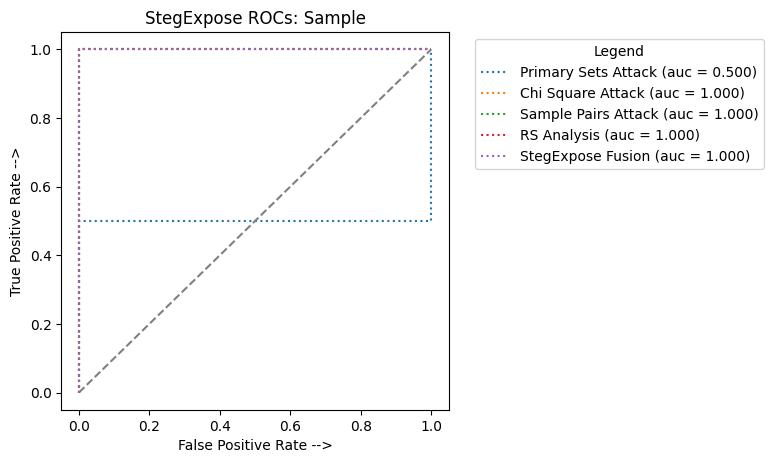

In [19]:
stegexpose_print_all_rocs(stegexpose_results, stegexpose_actuals, indices, names, title_suffix='Sample')

### SteganoGAN

In [20]:
basic_half_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_b10_limit_half_hs16_10epochs'
basic_full_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_b4_limitinf_hs32_10epochs'
basic_full_bossbase = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_Full_BOSSBase'
dense_half_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Dense_b10_limit_half_hs16_10epochs'
input_path = '/content/drive/MyDrive/steganet_images/our_animals'

In [21]:
def steganogan_file_ck(name):
  if 'enc' in name:
    return 1
  else:
    return 0

In [22]:
!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/our_animals default default steganogan_inputs.csv
!awk '!/^$/' steganogan_inputs.csv > steganogan_inputs_clean.csv
stegexpose_steganogan_inputs = 'steganogan_inputs_clean.csv'

stegexpose_steganogan_results = []

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Basic_b10_limit_half_hs16_10epochs default default steganogan_basic_half.csv
!awk '!/^$/' steganogan_basic_half.csv > steganogan_basic_half_clean.csv
stegexpose_steganogan_results.append('steganogan_basic_half_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Basic_b4_limitinf_hs32_10epochs default default steganogan_basic_full.csv
!awk '!/^$/' steganogan_basic_full.csv > steganogan_basic_full_clean.csv
stegexpose_steganogan_results.append('steganogan_basic_full_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Basic_Full_BOSSBase default default steganogan_basic_full_bossbase.csv
!awk '!/^$/' steganogan_basic_full_bossbase.csv > steganogan_basic_full_bossbase_clean.csv
stegexpose_steganogan_results.append('steganogan_basic_full_bossbase_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Basic_Half_BOSSBase default default steganogan_basic_half_bossbase.csv
!awk '!/^$/' steganogan_basic_half_bossbase.csv > steganogan_basic_half_bossbase_clean.csv
stegexpose_steganogan_results.append('steganogan_basic_half_bossbase_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Dense_b10_limit_half_hs16_10epochs default default steganogan_dense_half.csv
!awk '!/^$/' steganogan_dense_half.csv > steganogan_dense_half_clean.csv
stegexpose_steganogan_results.append('steganogan_dense_half_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Dense_Half_BOSSBase default default steganogan_dense_half_bossbase.csv
!awk '!/^$/' steganogan_dense_half_bossbase.csv > steganogan_dense_half_bossbase_clean.csv
stegexpose_steganogan_results.append('steganogan_dense_half_bossbase_clean.csv')



In [23]:
import pandas as pd

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  for f in stegexpose_steganogan_results:
    print(f'\nStegexpose results: {f}')
    stegexpose_analysis = pd.read_csv(f)
    display(stegexpose_analysis)


Stegexpose results: steganogan_basic_half_clean.csv


,File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sample Pairs,RS analysis,Fusion (mean)
0,enc_1.png,False,448235,0.098561,0.000028,0.077050,0.075001,0.062660
1,enc_2.png,False,166450,0.073166,0.009178,NaN,0.054234,0.045526
2,enc_3.png,False,647706,0.040025,0.000143,0.150530,0.150138,0.085209
3,enc_4.png,False,607347,NaN,0.000053,0.116738,0.113410,0.076734
4,enc_5.png,False,319165,NaN,0.002254,0.063221,0.064343,0.043272
5,enc_6.png,False,205500,0.011255,0.001904,0.051743,0.049368,0.028568
6,enc_7.png,False,351000,0.051555,0.000139,0.069224,0.068755,0.047418
7,enc_8.png,False,137675,0.024344,0.001204,0.027951,0.024832,0.019583
8,enc_9.png,False,1490656,NaN,0.000753,0.257924,0.256020,0.171566
9,enc_10.png,False,655845,0.112302,0.002756,0.120958,0.115300,0.087829



Stegexpose results: steganogan_basic_full_clean.csv


,File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sample Pairs,RS analysis,Fusion (mean)
0,enc_1.png,False,82139,0.005449,0.000309,0.020595,0.019216,0.011392
1,enc_2.png,False,11945,0.005596,0.001551,NaN,0.002557,0.003234
2,enc_3.png,False,67255,0.017645,0.000938,0.006808,0.011208,0.009150
3,enc_4.png,False,96286,0.019163,0.001428,0.006667,0.024008,0.012816
4,enc_5.png,False,104357,0.001458,0.005064,0.025536,0.025611,0.014417
5,enc_6.png,False,46103,0.006961,0.003563,0.007655,0.006723,0.006226
6,enc_7.png,False,19835,0.003683,0.001048,0.003553,0.002294,0.002644
7,enc_8.png,False,52202,0.009936,0.004045,0.007953,0.006752,0.007171
8,enc_9.png,False,37893,0.004384,0.001523,0.006393,0.005919,0.004555
9,enc_10.png,False,180268,0.023426,0.010505,0.032944,0.029433,0.024077



Stegexpose results: steganogan_basic_full_bossbase_clean.csv


,File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sample Pairs,RS analysis,Fusion (mean)
0,enc_2.png,False,127307,0.067358,0.004516,NaN,0.056958,0.042944
1,enc_3.png,False,104716,0.023184,0.000322,0.020402,0.019998,0.015976
2,enc_4.png,False,94234,0.019093,0.000337,0.018220,0.018249,0.013975
3,enc_5.png,False,77964,0.019423,0.000102,0.018203,0.017923,0.013913
4,enc_6.png,False,46812,0.009127,0.000808,0.010183,0.010636,0.007688
5,enc_7.png,False,123095,0.024378,0.000428,0.027059,0.027676,0.019885
6,enc_8.png,False,35028,0.008488,0.000791,0.007997,0.007367,0.006161
7,enc_9.png,False,277379,0.052275,0.000197,0.047945,0.049106,0.037381
8,enc_10.png,False,36605,0.008378,0.001265,0.007334,0.006564,0.005885
9,enc_11.png,False,443937,0.083232,0.001438,0.062711,0.067356,0.053684



Stegexpose results: steganogan_basic_half_bossbase_clean.csv


,File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sample Pairs,RS analysis,Fusion (mean)
0,enc_1.png,False,54489,0.017037,0.000049,0.008729,0.007166,0.008246
1,enc_10.png,False,64341,0.005243,0.011665,0.009080,0.008169,0.008539
2,enc_11.png,False,30898,0.006360,0.002376,0.001635,0.004245,0.003654
3,enc_2.png,False,17699,0.007994,0.001127,NaN,0.007338,0.005486
4,enc_3.png,False,98685,0.018688,0.000757,0.019901,0.017816,0.014291
5,enc_4.png,False,138939,0.027439,0.000756,0.028526,0.024983,0.020426
6,enc_6.png,False,35454,0.006268,0.001764,0.006040,0.007336,0.005352
7,enc_5.png,False,95615,0.024300,0.000424,0.007834,0.021433,0.013498
8,enc_7.png,False,21825,0.005955,0.000460,0.002914,0.003607,0.003234
9,enc_8.png,False,79535,0.017401,0.003328,0.013063,0.010505,0.011074



Stegexpose results: steganogan_dense_half_clean.csv


,File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sample Pairs,RS analysis,Fusion (mean)
0,olive_test.png,False,309554,NaN,0.001075,0.068185,0.063354,0.044204
1,enc_3.png,False,862512,0.058512,0.000029,0.185212,0.187290,0.107761
2,enc_1.png,False,368117,0.074784,0.000000,0.059270,0.061506,0.048890
3,enc_2.png,False,193201,0.062538,0.003038,NaN,0.084537,0.050038
4,enc_4.png,False,943527,NaN,0.000418,0.167885,0.165919,0.111407
5,enc_5.png,False,967421,NaN,0.002918,0.189799,0.183468,0.125395
6,enc_6.png,False,234728,0.007735,0.000113,0.055285,0.059201,0.030583
7,enc_7.png,False,632838,0.087513,0.000022,0.116286,0.119548,0.080842
8,enc_8.png,False,242641,0.050914,0.001602,0.037447,0.039675,0.032410
9,enc_9.png,True,2033115,NaN,0.000058,0.338109,0.339773,0.225980



Stegexpose results: steganogan_dense_half_bossbase_clean.csv


,File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sample Pairs,RS analysis,Fusion (mean)
0,enc_1.png,False,69010,0.016622,0.000028,0.017773,0.017077,0.012875
1,enc_10.png,False,92393,0.011819,0.001315,0.023938,0.023181,0.015063
2,enc_2.png,False,15466,0.004976,0.005926,NaN,0.003957,0.004953
3,enc_11.png,False,603632,0.009315,0.000172,0.138006,0.138107,0.071400
4,enc_3.png,False,226975,0.025123,0.000221,0.058262,0.054686,0.034573
5,enc_4.png,False,260589,0.066492,0.002761,0.039774,0.038001,0.036757
6,enc_6.png,False,61799,0.002773,0.002026,0.019232,0.018815,0.010712
7,enc_5.png,False,185763,0.072693,0.000346,0.029179,0.029705,0.032981
8,enc_7.png,False,16285,0.000649,0.003987,0.002667,0.003290,0.002648
9,enc_8.png,False,19511,0.001294,0.000500,0.007383,0.005768,0.003736


In [24]:
print(stegexpose_steganogan_inputs)
(files_i, actuals_i, results_i) = stegexpose_file_to_data(stegexpose_steganogan_inputs, file_ck_fn=steganogan_file_ck)

steganogan_stegexpose_data = []
for f in stegexpose_steganogan_results:
  (files, actuals, results) = stegexpose_file_to_data(f, file_ck_fn=steganogan_file_ck)
  steganogan_stegexpose_data.append((files, actuals, results))

steganogan_inputs_clean.csv


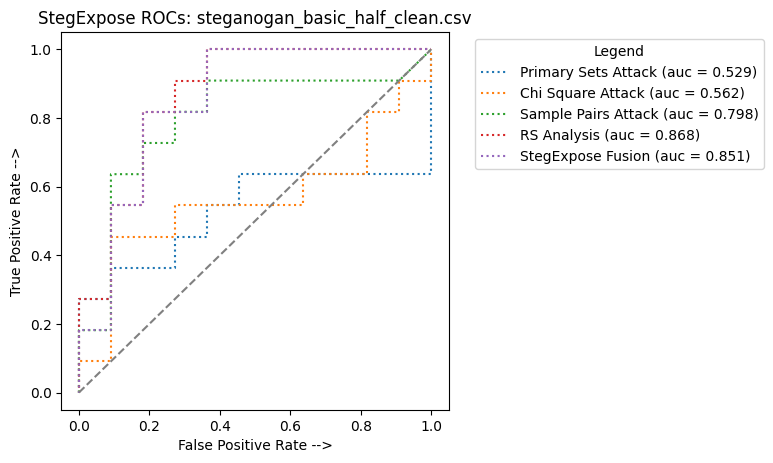

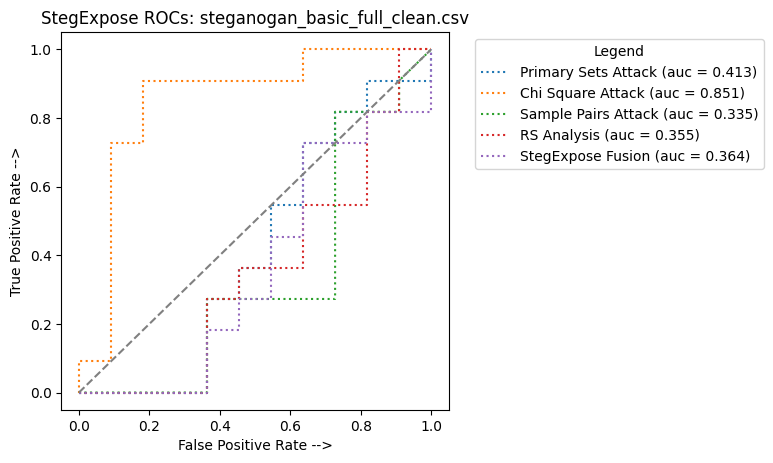

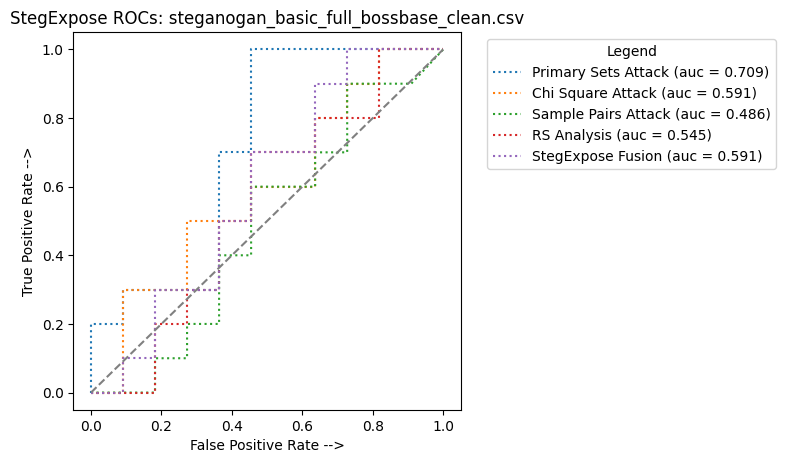

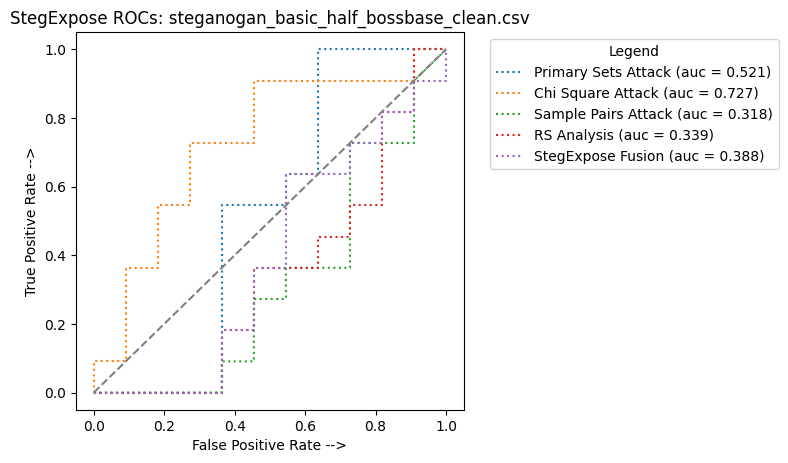

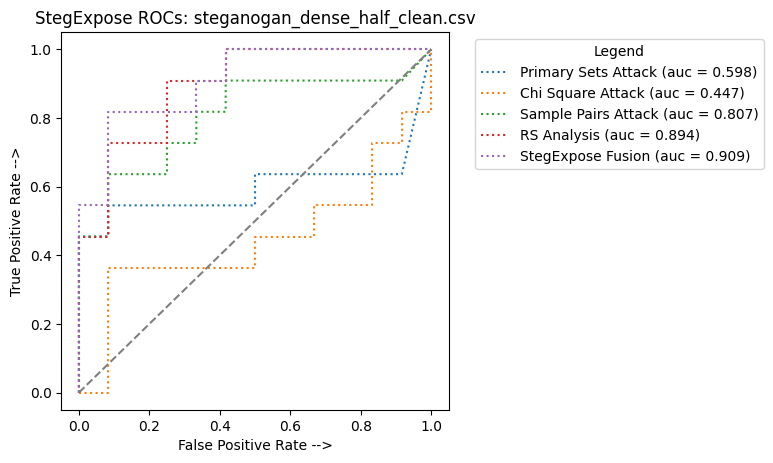

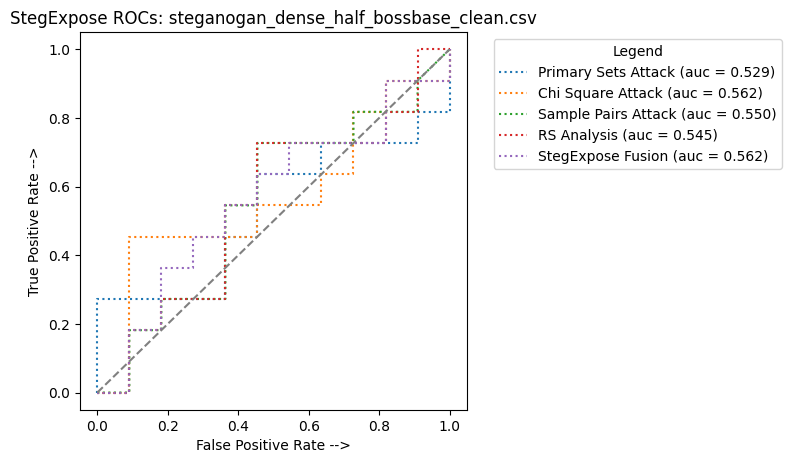

In [25]:
for (fname, (files, actuals, results)) in zip(stegexpose_steganogan_results, steganogan_stegexpose_data):
  files = np.concatenate((files, files_i), axis=0)
  actuals = np.concatenate((actuals, actuals_i))
  results = np.concatenate((results, results_i))
  stegexpose_print_all_rocs(results, actuals, indices, names, title_suffix=fname)

## Neural Steganalysis

We use `Alethia` to evaluate our encoded images using pre-trained models for detecting our main encoding type.

### Sample

#### Overall Results

In [26]:
!python aletheia/aletheia.py effnetb0-predict aletheia/sample_images/alaska2jpg/ aletheia/aletheia-models/effnetb0-A-alaska2-steghide.h5 0 > aletheia.txt

2021-06-10 06:12:31.569473: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-10 06:12:33.125622: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-10 06:12:33.145856: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-06-10 06:12:33.145903: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b7a63561871b): /proc/driver/nvidia/version does not exist
2021-06-10 06:12:36.237713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-06-10 06:12:36.238566: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz
2021-06-10 06:12:37.466135: W tensorflow/core/framework/cpu_allocator_impl.c

In [27]:
!echo "filename,prediction" > aletheia.csv
!egrep -i '^(/?[^/ ]*)+/? (0|1)\.[0-9]*$' aletheia.txt | sed -e "s/ /,/g" >> aletheia.csv

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  alethai_analysis = pd.read_csv('aletheia.csv')
  display(alethai_analysis)

,filename,prediction
0,aletheia/sample_images/alaska2jpg/01294.jpg,0.000
1,aletheia/sample_images/alaska2jpg/01497_juniw.jpg,0.000
2,aletheia/sample_images/alaska2jpg/04965.jpg,0.000
3,aletheia/sample_images/alaska2jpg/08452_outgue...,1.000
4,aletheia/sample_images/alaska2jpg/08929_nsf5.jpg,0.001
5,aletheia/sample_images/alaska2jpg/09098_steghi...,0.992
6,aletheia/sample_images/alaska2jpg/23199_steghi...,0.655
7,aletheia/sample_images/alaska2jpg/27733_nsf5.jpg,0.000
8,aletheia/sample_images/alaska2jpg/35517_juniw.jpg,0.000
9,aletheia/sample_images/alaska2jpg/35800_outgue...,1.000


### SteganoGAN

In [28]:
basic_half_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_b10_limit_half_hs16_10epochs'
basic_full_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_b4_limitinf_hs32_10epochs'
basic_full_bossbase = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_Full_BOSSBase'
dense_half_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Dense_b10_limit_half_hs16_10epochs'
input_path = '/content/drive/MyDrive/steganet_images/our_animals'

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/our_animals > aletheia_inputs.txt
!cat aletheia_inputs.txt | awk '/\*/{f=1}f' > aletheia_inputs_clean.txt
aletheia_steganogan_inputs = 'aletheia_inputs_clean.txt'

aletheia_steganogan_results = []

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/Encoded_images_Basic_b10_limit_half_hs16_10epochs > aletheia_basic_half.txt
!cat aletheia_basic_half.txt | awk '/\*/{f=1}f' > aletheia_basic_half_clean.txt
aletheia_steganogan_results.append('aletheia_basic_half_clean.txt')

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/Encoded_images_Basic_b4_limitinf_hs32_10epochs > aletheia_basic_full.txt
!cat aletheia_basic_full.txt | awk '/\*/{f=1}f' > aletheia_basic_full_clean.txt
aletheia_steganogan_results.append('aletheia_basic_full_clean.txt')

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/Encoded_images_Basic_Full_BOSSBase > aletheia_basic_full_bossbase.txt
!cat aletheia_basic_full_bossbase.txt | awk '/\*/{f=1}f' > aletheia_basic_full_bossbase_clean.txt
aletheia_steganogan_results.append('aletheia_basic_full_bossbase_clean.txt')

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/Encoded_images_Basic_Half_BOSSBase > aletheia_basic_half_bossbase.txt
!cat aletheia_basic_half_bossbase.txt | awk '/\*/{f=1}f' > aletheia_basic_half_bossbase_clean.txt
aletheia_steganogan_results.append('aletheia_basic_half_bossbase_clean.txt')

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/Encoded_images_Dense_b10_limit_half_hs16_10epochs > aletheia_dense_half.txt
!cat aletheia_dense_half.txt | awk '/\*/{f=1}f' > aletheia_dense_half_clean.txt
aletheia_steganogan_results.append('aletheia_dense_half_clean.txt')

!python aletheia/aletheia.py auto /content/drive/MyDrive/steganet_images/Encoded_images_Dense_Half_BOSSBase > aletheia_dense_half_bossbase.txt
!cat aletheia_dense_half_bossbase.txt | awk '/\*/{f=1}f' > aletheia_dense_half_bossbase_clean.txt
aletheia_steganogan_results.append('aletheia_dense_half_bossbase_clean.txt')

2021-06-10 06:12:47.502205: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-10 06:12:49.020992: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-10 06:12:49.033099: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-06-10 06:12:49.033147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b7a63561871b): /proc/driver/nvidia/version does not exist
2021-06-10 06:12:56.974879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-06-10 06:12:56.975320: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz
2021-06-10 06:12:58.592667: W tensorflow/core/framework/cpu_allocator_impl.c

In [29]:
!cat aletheia_inputs_clean.txt

                       LSBR      LSBM  SteganoGAN  HILL *
---------------------------------------------------------
INPUT_1.png             0.0       0.0      0.0      0.0   
INPUT_2.png             0.0       0.0      0.0      0.0   
INPUT_3.png             0.0       0.0      0.0      0.0   
INPUT_4.png             0.0       0.1      0.0      0.1   
INPUT_5.png             0.0       0.0      0.0      0.0   
INPUT_6.png             0.0       0.0      0.0      0.0   
INPUT_7.png             0.0       0.0      0.0      0.0   
INPUT_8.png             0.0       0.0      0.0      0.0   
INPUT_9.png             0.0       0.0      0.0      0.0   
INPUT_10.png            0.0       0.0      0.0      0.0   
INPUT_11.png            0.0       0.0      0.0      0.0   

* Probability of being stego using the indicated steganographic method.



In [30]:
def aletheia_file_to_data(filename, file_ck_fn=None):
  files = []
  results = []
  actuals = []
  with open(filename, mode='r') as table:
    labels = next(table).split()[0:4]
    labels.insert(0, 'Filename')
    next(table) # skip "------" line
    for row in table:
      row = row.split()
      if (len(row) == 0): # empty row
        continue
      if (row[0] == "*"): # last row
        continue
      files.append(row[0])
      these_results = [r.replace("[", "").replace("]","") for r in row[1:]]
      results.append(these_results)
      label = 1 # assume it was encoded unless it's an input image
      if file_ck_fn is not None:
        label = file_ck_fn(row[0])
        actuals.append(label)
  files = np.array(files)
  results = np.array(results)
  actuals = np.array(actuals)
  return files, actuals, results, labels

In [31]:
def aletheia_file_ck(name):
  if name is not None:
    if 'enc' in name or 'ENC' in name:
      return 1
    else:
      return 0
  return 0

In [32]:
aletheia_file_to_data('aletheia_basic_half_clean.txt', file_ck_fn=aletheia_file_ck)

(array(['enc_1.png', 'enc_2.png', 'enc_3.png', 'enc_4.png', 'enc_5.png',
        'enc_6.png', 'enc_7.png', 'enc_8.png', 'enc_9.png', 'enc_10.png',
        'enc_11.png'], dtype='<U10'),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([['0.9', '1.0', '1.0', '0.4'],
        ['1.0', '1.0', '1.0', '1.0'],
        ['0.9', '0.9', '1.0', '0.9'],
        ['1.0', '1.0', '1.0', '0.8'],
        ['0.9', '1.0', '0.0', '0.8'],
        ['0.8', '1.0', '1.0', '0.9'],
        ['0.9', '1.0', '0.8', '1.0'],
        ['0.9', '1.0', '0.1', '0.9'],
        ['0.7', '1.0', '0.0', '0.8'],
        ['0.4', '0.9', '0.2', '0.8'],
        ['0.9', '0.9', '1.0', '0.8']], dtype='<U3'),
 ['Filename', 'LSBR', 'LSBM', 'SteganoGAN', 'HILL'])

In [33]:
def aletheia_extract_column(csv_data, idx):
  results = np.array([float(r) if 'null' not in r else float(0) for r in csv_data[:,idx] ])
  results = np.nan_to_num(results)
  # print(f'Extracted column {idx}: {results}')
  return results

In [34]:
def aletheia_print_all_rocs(results, actuals, labels, title_suffix=None):
  y_preds = []
  my_names = []
  for idx, name in enumerate(labels[1:]):
    my_names.append(name)
    y_preds.append(extract_column(results,idx))
  title = 'Aletheia ROCs'
  if title_suffix is not None:
    title = title + f': {title_suffix}'
  print_rocs(actuals, y_preds, my_names, title=title)

In [35]:
(files_i, actuals_i, results_i, labels_i) = aletheia_file_to_data(aletheia_steganogan_inputs, file_ck_fn=aletheia_file_ck)

steganogan_aletheia_data = []
for f in aletheia_steganogan_results:
  (files, actuals, results, labels) = aletheia_file_to_data(f, file_ck_fn=aletheia_file_ck)
  steganogan_aletheia_data.append((files, actuals, results, labels))

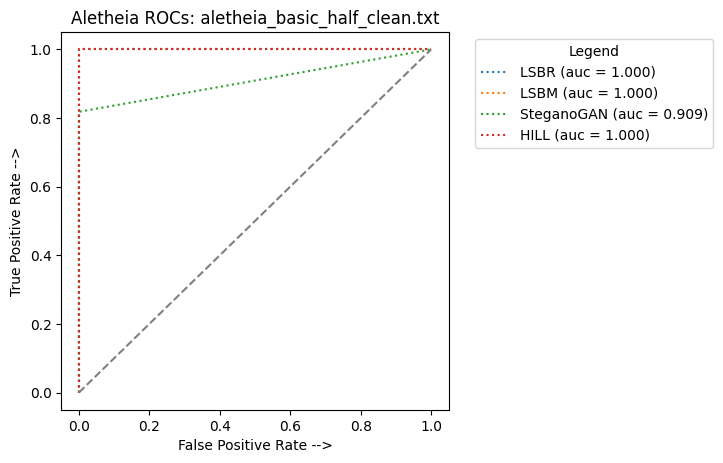

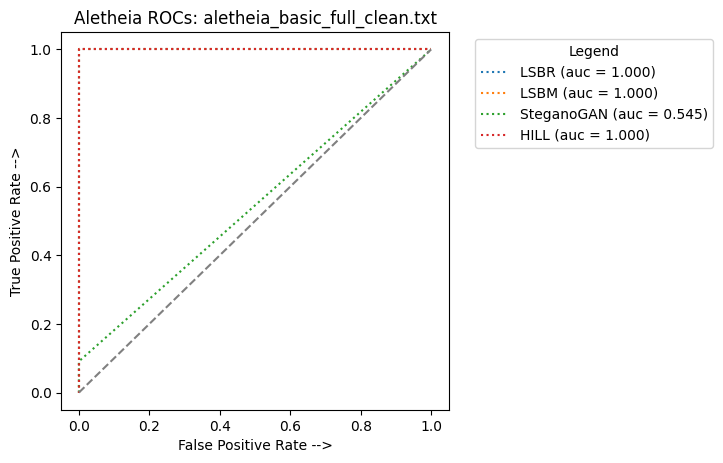

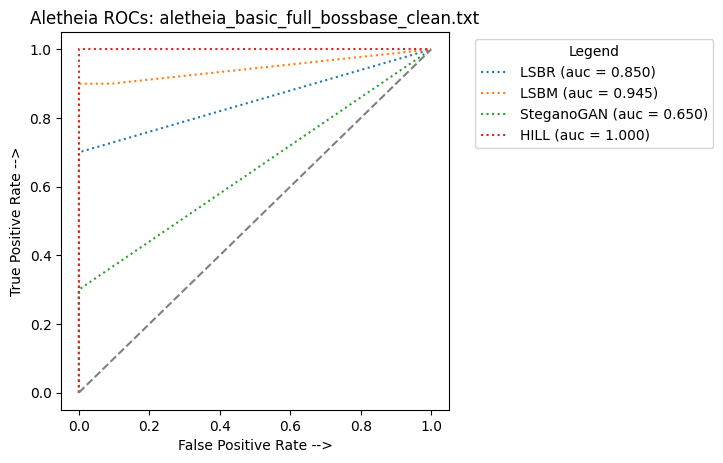

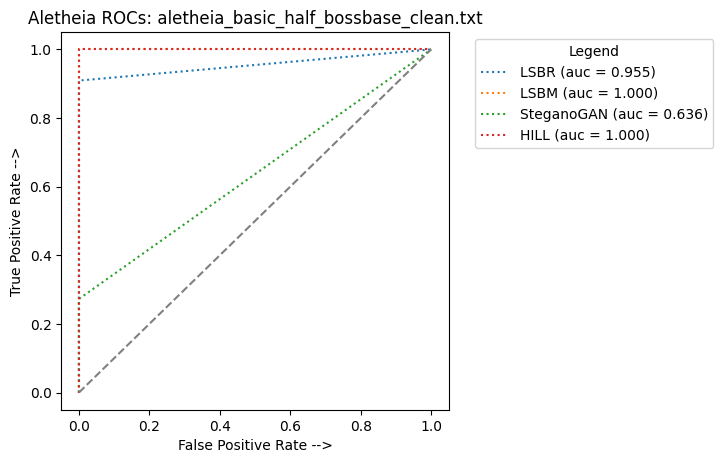

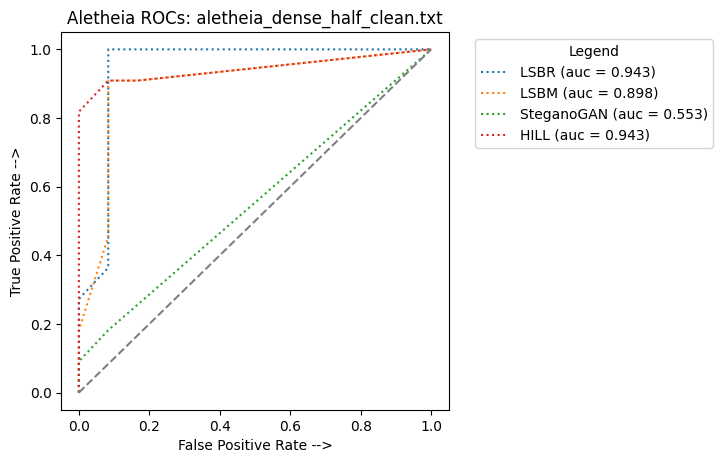

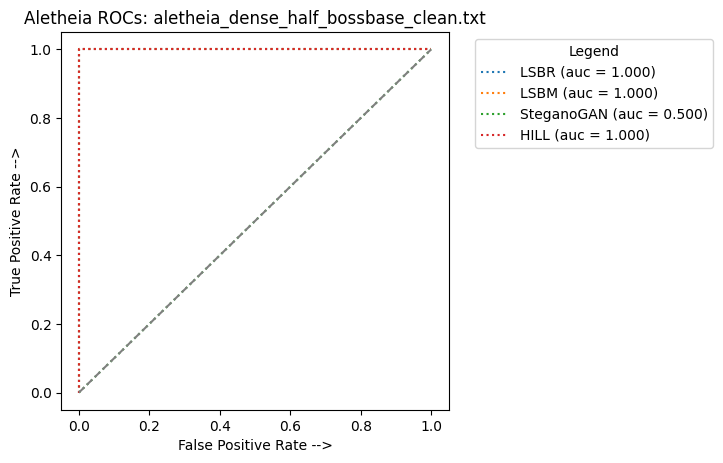

In [36]:
for (fname, (files, actuals, results, labels)) in zip(aletheia_steganogan_results, steganogan_aletheia_data):
  files = np.concatenate((files, files_i), axis=0)
  actuals = np.concatenate((actuals, actuals_i))
  results = np.concatenate((results, results_i))
  aletheia_print_all_rocs(results, actuals, labels, title_suffix=fname)

## Combined

In [37]:
def combined_print_all_rocs(results, actuals, labels, title_suffix=None):
  y_preds = []
  my_names = []
  for idx, name in enumerate(labels[1:]):
    my_names.append(name)
    y_preds.append(extract_column(results,idx))
  title = 'Combined ROCs'
  if title_suffix is not None:
    title = title + f': {title_suffix}'
  print_rocs(actuals, y_preds, my_names, title=title)

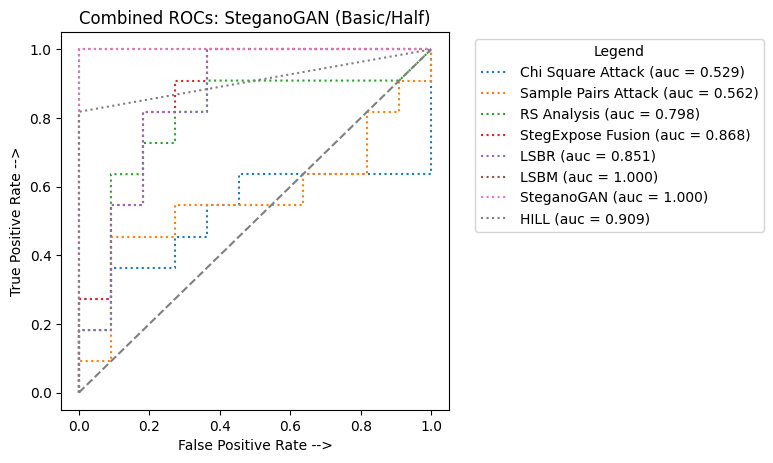

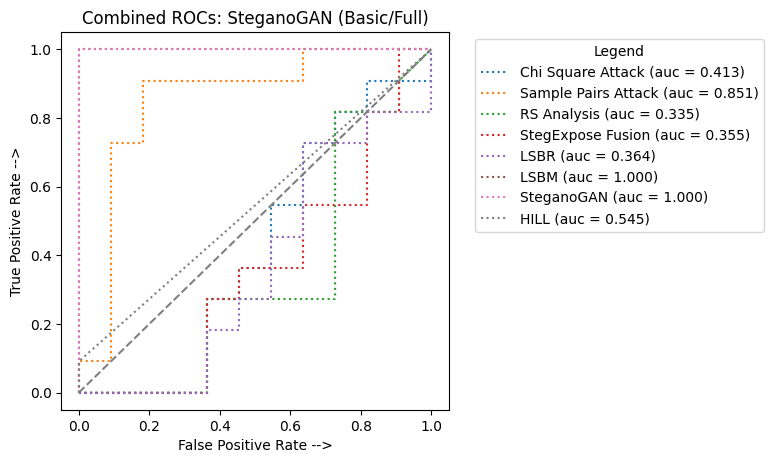

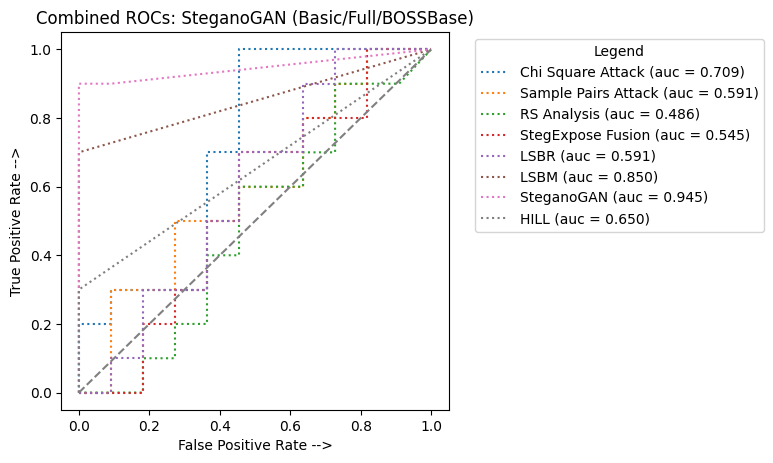

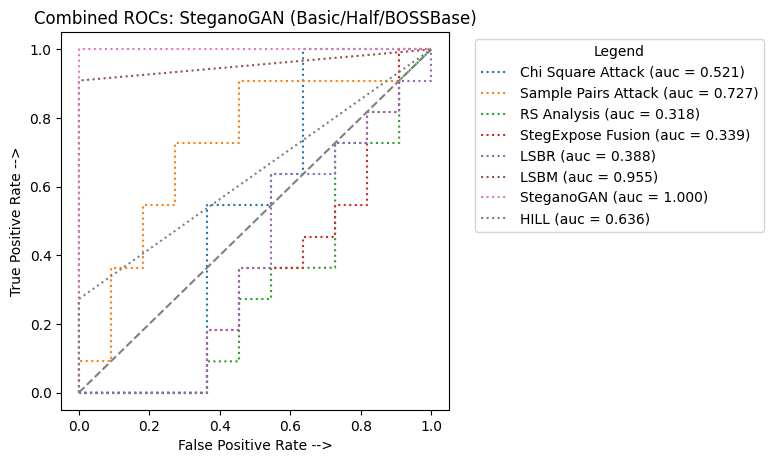

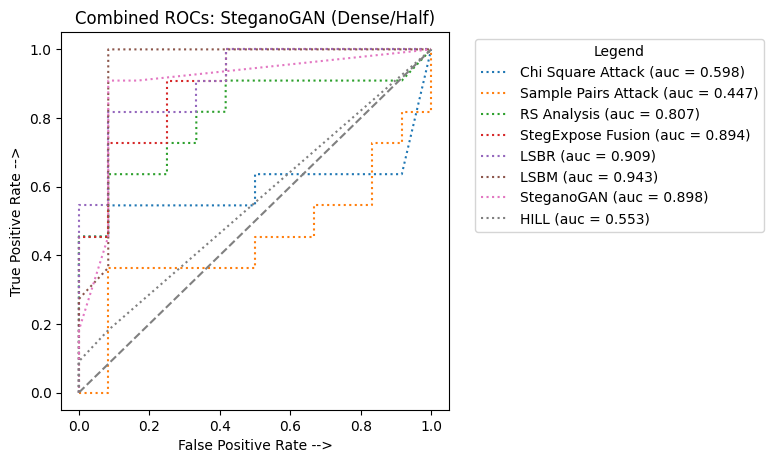

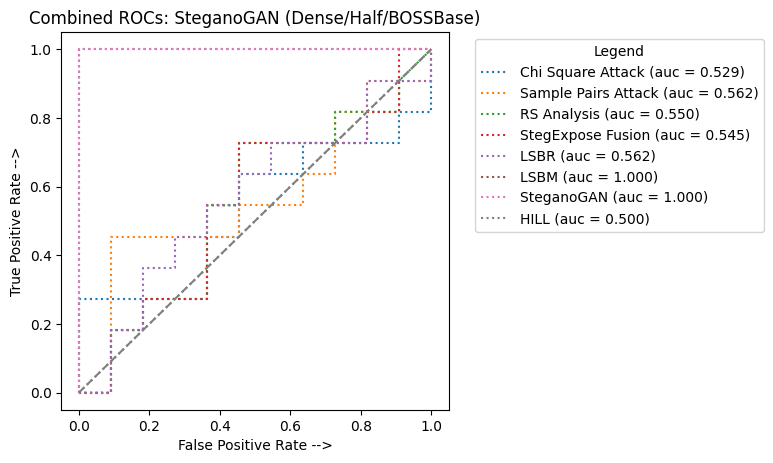

In [39]:
result_titles = ['SteganoGAN (Basic/Half)', 'SteganoGAN (Basic/Full)', 'SteganoGAN (Basic/Full/BOSSBase)', 'SteganoGAN (Basic/Half/BOSSBase)', 'SteganoGAN (Dense/Half)', 'SteganoGAN (Dense/Half/BOSSBase)']

(files_i_s, actuals_i_s, results_i_s) = stegexpose_file_to_data(stegexpose_steganogan_inputs, file_ck_fn=steganogan_file_ck)
(files_i_a, actuals_i_a, results_i_a, labels_i_a) = aletheia_file_to_data(aletheia_steganogan_inputs, file_ck_fn=aletheia_file_ck)

for (title, (_, actuals_s, results_s), (_, actuals_a, results_a, labels_a)) in zip(result_titles, steganogan_stegexpose_data, steganogan_aletheia_data):
  # Normalize input data
  labels_s = np.array(names)
  labels_a = np.array(labels_a)[1:]
  # Combine StegExpose results with input (un-encoded) images
  actuals_s = np.concatenate((actuals_s, actuals_i_s))
  results_s = np.concatenate((results_s, results_i_s))
  # Combine Aletheia results with input (un-encoded) images
  actuals_a = np.concatenate((actuals_a, actuals_i_a))
  results_a = np.concatenate((results_a, results_i_a))
  # Combine StegExpose and Aletheia results

  # print(title)
  # print('Stegexpose data:')
  # print(f'actuals_s ({actuals_s.shape}): {actuals_s}')
  # print(f'results_s ({results_s.shape}): {results_s}')
  # print(f'labels_s ({labels_s.shape}): {labels_s}')
  # print('Alethia data:')
  # print(f'actuals_a ({actuals_a.shape}): {actuals_a}')
  # print(f'results_a ({results_a.shape}): {results_a}')
  # print(f'labels_a ({labels_a.shape}): {labels_a}')

  if (False == np.all(np.equal(actuals_s, actuals_a))):
    print('Actuals labelings are not consistent!!!')
    continue
  actuals = actuals_s
  # print(f'actuals ({actuals.shape}): {actuals}')
  results = np.concatenate((results_s, results_a), axis=1)
  # print(f'results ({results.shape}): {results}')
  labels = np.concatenate((labels_s, labels_a), axis=0)
  # print(f'labels: ({labels.shape}): {labels}')

  combined_print_all_rocs(results, actuals, labels, title_suffix=title)